In [46]:
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, AutoModel
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import datasets
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader

import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [47]:
# load_dataset() returns a dictionary. keys are the (train, validation, text) and values are datasets for each
dataset = datasets.load_dataset("ttxy/emotion")

print(dataset.shape)

# create a pandas dataframe for each dataset (train, test, validation)
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])
valid_df = pd.DataFrame(dataset["validation"])

print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)
train_df.head()

{'train': (16000, 2), 'validation': (2000, 2), 'test': (2000, 2)}
(16000, 2)
(2000, 2)
(2000, 2)


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


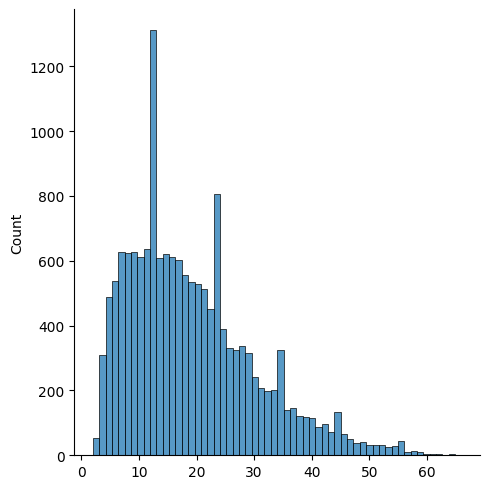

Average document length: 19.2 tokens


In [48]:
# vizualize text length
doc_lengths = []

for text in train_df['text']:
    tokens = nltk.word_tokenize(text)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.displot(doc_lengths)
plt.show()
print(f"Average document length: {np.average(doc_lengths):.1f} tokens")

In [49]:
# Check training data distribution
print("\nTraining set label distribution:")
print(train_df['label'].value_counts().sort_index())
print("\nTraining set percentages:")
print(train_df['label'].value_counts(normalize=True).sort_index() * 100)


Training set label distribution:
label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64

Training set percentages:
label
0    29.16250
1    33.51250
2     8.15000
3    13.49375
4    12.10625
5     3.57500
Name: proportion, dtype: float64


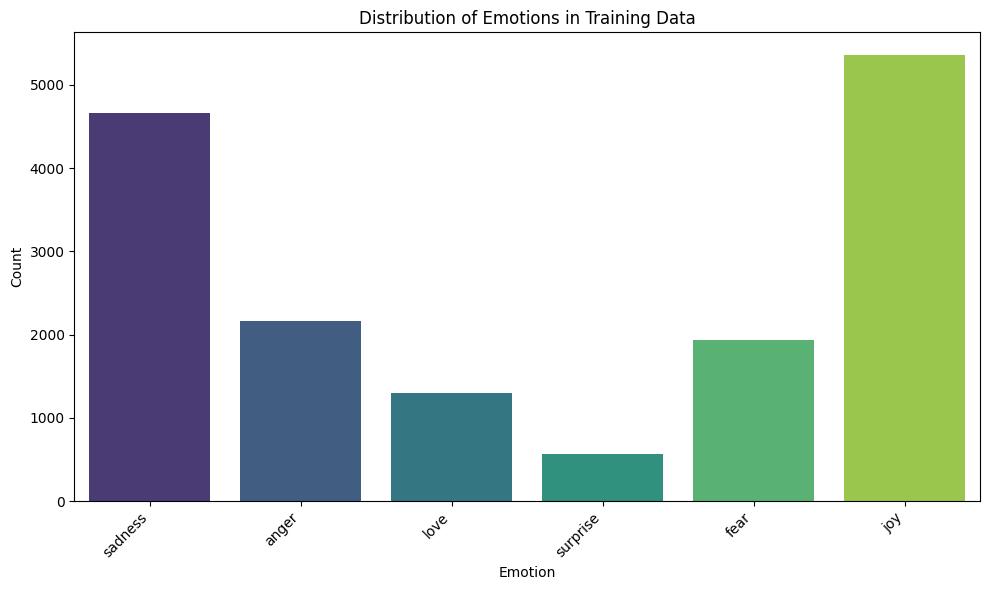

In [50]:
# Plot the distribution
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

plot_df = train_df.copy()
plot_df['sentiment_name'] = plot_df['label'].map(lambda x: class_names[x])

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sentiment_name', data=plot_df, palette='viridis', hue='sentiment_name', legend=False)
plt.title('Distribution of Emotions in Training Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [51]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [52]:
# Load pre-traind BERT model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [53]:
# Tokenize

pad_len = 50

tokens_train = tokenizer.batch_encode_plus(
    train_df['text'].tolist(),
    max_length = pad_len,
    padding = 'max_length',
    truncation = True
)

tokens_val = tokenizer.batch_encode_plus(
    valid_df['text'].tolist(),
    max_length = pad_len,
    padding = 'max_length',
    truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
    test_df['text'].tolist(),
    max_length = pad_len,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_df['label'].tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(valid_df['label'].tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_df['label'].tolist())

In [54]:
# Create Dataloaders
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = torch.utils.data.SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")

Training batches: 500
Validation batches: 63


In [55]:
# Freeze the pretrained layers
for param in bert.parameters():
    param.requires_grad = True

#defining new layers
class SentimentClassifier(nn.Module):

    def __init__(self, bert, num_classes):

      super(SentimentClassifier, self).__init__()

      self.bert = bert

      self.dropout = nn.Dropout(0.2)

      self.relu =  nn.ReLU()

      self.fc1 = nn.Linear(768,512)

      self.fc2 = nn.Linear(512, num_classes)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = cls_hs

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # Return raw logits
      return x

In [56]:
# Optimizer
# Determine the number of unique classes from the training data labels and initialize
num_classes = train_df['label'].nunique()

model = SentimentClassifier(bert, num_classes)

model.to(device)

learning_rate = 2e-6

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Calculate class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights applied:")
label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
for i, (name, weight) in enumerate(zip(label_names, class_weights)):
    print(f"  {name} (class {i}): {weight:.2f}")

# Use unweighted CrossEntropyLoss
#cross_entropy = CrossEntropyLoss().to(device)

# Use weighted CrossEntropyLoss
cross_entropy = CrossEntropyLoss(weight=class_weights).to(device)

Class weights applied:
  sadness (class 0): 0.57
  joy (class 1): 0.50
  love (class 2): 2.04
  anger (class 3): 1.24
  fear (class 4): 1.38
  surprise (class 5): 4.66


In [57]:
# Train the Model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  total_preds=[]

  for step,batch in enumerate(train_dataloader):

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    model.zero_grad()

    preds = model(sent_id, mask)

    loss = cross_entropy(preds, labels)

    total_loss = total_loss + loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

    preds=preds.detach().cpu().numpy()

    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)

  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [58]:
# Evaluate the Model
def evaluate():

  print("\nEvaluating...")

  model.eval()

  total_loss, total_accuracy = 0, 0

  total_preds = []

  for step,batch in enumerate(val_dataloader):

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    with torch.no_grad():

      preds = model(sent_id, mask)

      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  avg_loss = total_loss / len(val_dataloader)

  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [59]:
# Training Loop
from transformers import get_linear_schedule_with_warmup

# Set number of epochs
epochs = 4

# Setup scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Lists to store losses
train_losses = []
valid_losses = []

# Training loop
for epoch in range(epochs):
    print(f'\n{"="*50}')
    print(f'Epoch {epoch + 1} / {epochs}')
    print(f'{"="*50}')

    train_loss, _ = train()

    valid_loss, _ = evaluate()

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

print("\nTraining complete!")


Epoch 1 / 4
  Batch    50  of    500.
  Batch   100  of    500.


KeyboardInterrupt: 

In [ ]:
# Test Evaluation
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Create test dataloader
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = torch.utils.data.SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

model.eval()

all_preds = []
all_labels = []

print("Testing model...")

# Iterate through test data in batches
with torch.no_grad():
    for batch in test_dataloader:
        sent_id, mask, labels = [t.to(device) for t in batch]

        preds = model(sent_id, mask)

        preds = preds.detach().cpu().numpy()
        labels = labels.cpu().numpy()

        pred_classes = np.argmax(preds, axis=1)

        all_preds.extend(pred_classes)
        all_labels.extend(labels)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)

print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\n" + "="*50)
print("Classification Report:")
print("="*50)

label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
report_str = classification_report(all_labels, all_preds, target_names=label_names)
print(report_str)

# ---- NEW: CLASSIFICATION REPORT TABLE ----
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert classification report to dict → dataframe
report_dict = classification_report(all_labels, all_preds, target_names=label_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(8, 4))
plt.title("Classification Report Table")
plt.axis("off")
tbl = plt.table(
    cellText=report_df.round(3).values,
    colLabels=report_df.columns,
    rowLabels=report_df.index,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
plt.show()

# ----------------------------------------------------

# Confusion Matrix
print("\n" + "="*50)
print("Confusion Matrix:")
print("="*50)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Per-class accuracy
print("\n" + "="*50)
print("Per-Class Accuracy:")
print("="*50)

per_class_data = []
for i, label in enumerate(label_names):
    class_mask = all_labels == i
    class_accuracy = accuracy_score(all_labels[class_mask], all_preds[class_mask])
    per_class_data.append([label, class_accuracy])
    print(f"{label}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

# ---- NEW: PER-CLASS ACCURACY TABLE ----
per_class_df = pd.DataFrame(per_class_data, columns=["Label", "Accuracy"])

plt.figure(figsize=(5, 3))
plt.title("Per-Class Accuracy Table")
plt.axis("off")
tbl = plt.table(
    cellText=per_class_df.round(3).values,
    colLabels=per_class_df.columns,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
plt.show()